<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/AAV_SelfSupervised_06_GoogleNet_2_layer_hidden_projection_head_earlystopping_pd512v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using fine tuned GoogleNet

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import numpy as np
from PIL import Image
from google.colab import drive
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import os
import zipfile
import glob
import shutil
from collections import Counter
from scipy import stats
from collections import Counter

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset path
zip_path = "/content/drive/MyDrive/AAVDATASET/100mV1s_segment_raw.zip"
extract_path = "/content/dataset/"
data_dir = '/content/dataset/train_val_photos'
# Unzip dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
data_dir = '/content/dataset/train_val_photos'
checkpoint_dir = os.path.join(data_dir, '.ipynb_checkpoints')
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

In [ ]:
# Valid image extensions.
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def is_valid_file(file_path):
    """Filters out hidden files and directories."""
    base_name = os.path.basename(file_path)
    if base_name.startswith('.'):  # Check for hidden files and directories
        return False
    return file_path.lower().endswith(valid_extensions)

# Dictionary to store subfolder name and file count
file_counts = {}

# Get the list of subdirectories (classes)
classes = os.listdir(data_dir)

for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path): # Ensure it's a directory
        # Count files in the subdirectory, filtering for valid files
        count = sum(1 for entry in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, entry)) and is_valid_file(os.path.join(class_path, entry)))
        file_counts[class_name] = count

# Print the file counts
total = 0
for class_name, count in file_counts.items():
    total += count
    print(f"Subfolder '{class_name}': {count} files")
print(f"Total files: {total}")

Subfolder 'Single': 1088 files
Subfolder 'Empty': 616 files
Subfolder 'Double': 1028 files
Total files: 2732


# Pre Training Task

Extend Training: Resume training from the best previous
model (e.g., epoch 40 or 138) with the new PROJ_DIM=512 and a lower LR (e.g., 2e-4) to refine the features.
Increase PATIENCE to 150 if needed.

**Batch Size Adjustment:** Reduce BATCH_SIZE to 128 or 64 to stabilize gradient updates with the larger projection dimension, then re-evaluate.

**Augmentation** Tuning: Slightly reduce augmentation strength (e.g., ColorJitter to 0.6, 0.6, 0.6, 0.1) to focus on more consistent features.

**Clustering** Refinement: After retraining, apply PCA before KMeans to reduce noise, or increase n_init=50 in KMeans for better initialization.

**Evaluate Progress:** Monitor loss and validation accuracy during retraining to ensure the model is improving.


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
import torchvision.transforms as T
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import umap
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
DATA_ROOT = "/content/dataset/train_val_photos"
BATCH_SIZE = 128
NUM_WORKERS = 8
LR = 5e-4
EPOCHS = 3000
TEMPERATURE = 0.07
PROJ_DIM = 512
PATIENCE = 250
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f"/content/drive/MyDrive/AAVDATASET/models/googlenet_simclr_two_layer_projection_head_pretrained__lr{LR:.5f}_t{TEMPERATURE:.2f}_e{EPOCHS}_b{BATCH_SIZE}_pd{PROJ_DIM}.pth"
FINAL_MODEL_PATH = MODEL_PATH.replace('.pth', '_final.pth')
INDICES_PATH = '/content/drive/MyDrive/AAVDATASET/models/dataset_indices.xlsx'

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# SimCLR augmentations
simclr_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.6, 0.6, 0.6, 0.1),
    T.RandomGrayscale(p=0.2),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Evaluation transform
eval_transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset and split
full_dataset = datasets.ImageFolder(DATA_ROOT)
full_samples = full_dataset.samples
n = len(full_samples)
train_len = int(0.8 * n)
val_len = int(0.1 * n)
test_len = n - train_len - val_len

generator = torch.Generator().manual_seed(42)
perm = torch.randperm(n, generator=generator).tolist()
train_idxs = perm[:train_len]
val_idxs = perm[train_len:train_len + val_len]
test_idxs = perm[train_len + val_len:]

# Save indices
pd.DataFrame({
    'Train_Indices': pd.Series(train_idxs),
    'Val_Indices': pd.Series(val_idxs),
    'Test_Indices': pd.Series(test_idxs)
}).to_excel(INDICES_PATH, index=False)

train_samples = [full_samples[i] for i in train_idxs]
val_samples = [full_samples[i] for i in val_idxs]
test_samples = [full_samples[i] for i in test_idxs]

# SimCLR Dataset
class SimCLRDataset(Dataset):
    def __init__(self, samples_list, transform):
        self.samples = samples_list
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, _ = self.samples[idx]
        img = Image.open(path).convert("RGB")
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

# Data loaders
ssl_train_ds = SimCLRDataset(train_samples, simclr_transform)
pretrain_loader = DataLoader(
    ssl_train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True,
    persistent_workers=True, prefetch_factor=2
)

eval_full_ds = datasets.ImageFolder(DATA_ROOT, transform=eval_transform)
train_eval_ds = Subset(eval_full_ds, train_idxs)
val_eval_ds = Subset(eval_full_ds, val_idxs)
test_eval_ds = Subset(eval_full_ds, test_idxs)

train_loader = DataLoader(
    train_eval_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)
val_loader = DataLoader(
    val_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)
test_loader = DataLoader(
    test_eval_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=2
)

# NT-Xent loss
def nt_xent(z, bs, temp):
    z = F.normalize(z, dim=1)
    sim = (z @ z.t()) / temp
    mask = (~torch.eye(2 * bs, dtype=bool)).to(DEVICE)
    exp_sim = torch.exp(sim.masked_select(mask).view(2 * bs, -1))
    pos = torch.exp((z[:bs] * z[bs:]).sum(dim=-1) / temp)
    positives = torch.cat([pos, pos], dim=0)
    return -torch.log(positives / exp_sim.sum(1)).mean()

# Model setup
backbone = models.googlenet(pretrained=True, aux_logits=True)
backbone.aux_logits = False
backbone.aux1 = None
backbone.aux2 = None
feat_dim = backbone.fc.in_features
backbone.fc = nn.Identity()
backbone = backbone.to(DEVICE)

projection_head = nn.Sequential(
    nn.Linear(feat_dim, feat_dim, bias=False),
    nn.BatchNorm1d(feat_dim),
    nn.ReLU(inplace=True),
    nn.Linear(feat_dim, feat_dim, bias=False),
    nn.BatchNorm1d(feat_dim),
    nn.ReLU(inplace=True),
    nn.Linear(feat_dim, PROJ_DIM, bias=True)
).to(DEVICE)

if hasattr(torch, 'compile'):
    backbone = torch.compile(backbone)
    projection_head = torch.compile(projection_head)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [ ]:
print(f"MODEL_PATH: {MODEL_PATH}")

MODEL_PATH: /content/drive/MyDrive/AAVDATASET/models/googlenet_simclr_two_layer_projection_head_pretrained__lr0.00050_t0.07_e3000_b128_pd512.pth


In [ ]:


optimizer = optim.Adam(
    list(backbone.parameters()) + list(projection_head.parameters()), lr=LR
)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()

num_classes = len(eval_full_ds.classes)
classifier = nn.Linear(feat_dim, num_classes).to(DEVICE)
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)

# Training loop with early stopping
best_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    backbone.train()
    projection_head.train()
    total_loss = 0.0
    start = time.time()

    for x1, x2 in pretrain_loader:
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            feats = backbone(torch.cat([x1, x2], 0))
            proj = projection_head(feats)
            loss = nt_xent(proj, x1.size(0), TEMPERATURE)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    scheduler.step()

    avg_loss = total_loss / len(pretrain_loader)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(backbone.state_dict(), MODEL_PATH)
        s = f" Saved new best backbone (loss {best_loss:.4f})"
    else:
        s = ""

    # Linear evaluation
    backbone.eval()
    classifier.train()
    for imgs, labels in train_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        logits = classifier(backbone(imgs))
        loss = F.cross_entropy(logits, labels)
        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

    # Validation
    classifier.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            preds = classifier(backbone(imgs)).argmax(1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'backbone_state_dict': backbone.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
        }, MODEL_PATH.replace('.pth', '_best_val.pth'))
        s += f" Saved best val model (acc {best_val_acc:.4f})"
    else:
        patience_counter += 1

    print(f"Epoch {epoch}/{EPOCHS} — Loss: {avg_loss:.4f} — Val Acc: {val_acc:.4f} — Time: {time.time()-start:.1f}s {s}")

    if patience_counter >= PATIENCE:
        print(f"Early stopping triggered after {epoch} epochs (no improvement in val_acc for {PATIENCE} epochs)")
        break

# Save final model
torch.save(backbone.state_dict(), FINAL_MODEL_PATH)
print(f"Saved final pretrained encoder to {FINAL_MODEL_PATH}")



<ipython-input-14-3145679533>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-14-3145679533>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-14-3145679533>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3000 — Loss: 5.3538 — Val Acc: 0.8278 — Time: 310.6s  Saved new best backbone (loss 5.3538) Saved best val model (acc 0.8278)


<ipython-input-14-3145679533>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/3000 — Loss: 4.6452 — Val Acc: 0.8388 — Time: 15.1s  Saved new best backbone (loss 4.6452) Saved best val model (acc 0.8388)
Epoch 3/3000 — Loss: 4.2748 — Val Acc: 0.8755 — Time: 15.1s  Saved new best backbone (loss 4.2748) Saved best val model (acc 0.8755)
Epoch 4/3000 — Loss: 3.9858 — Val Acc: 0.8791 — Time: 15.2s  Saved new best backbone (loss 3.9858) Saved best val model (acc 0.8791)
Epoch 5/3000 — Loss: 3.8028 — Val Acc: 0.8681 — Time: 14.7s  Saved new best backbone (loss 3.8028)
Epoch 6/3000 — Loss: 3.5681 — Val Acc: 0.8901 — Time: 15.3s  Saved new best backbone (loss 3.5681) Saved best val model (acc 0.8901)
Epoch 7/3000 — Loss: 3.5458 — Val Acc: 0.8901 — Time: 15.0s  Saved new best backbone (loss 3.5458)
Epoch 8/3000 — Loss: 3.4709 — Val Acc: 0.8791 — Time: 13.8s  Saved new best backbone (loss 3.4709)
Epoch 9/3000 — Loss: 3.4340 — Val Acc: 0.8901 — Time: 13.8s  Saved new best backbone (loss 3.4340)
Epoch 10/3000 — Loss: 3.2591 — Val Acc: 0.8828 — Time: 14.3s  Saved new 

Epoch 378/3000 — Loss: 0.5197 — Val Acc: 0.8498 — Time: 13.7s  Saved new best backbone (loss 0.5197)

Epoch 440/3000 — Loss: 0.4347 — Val Acc: 0.8938 — Time: 14.8s  Saved new best backbone (loss 0.4347)

Epoch 443/3000 — Loss: 0.4686 — Val Acc: 0.9084 — Time: 14.4s

Feature dimension: 1024


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


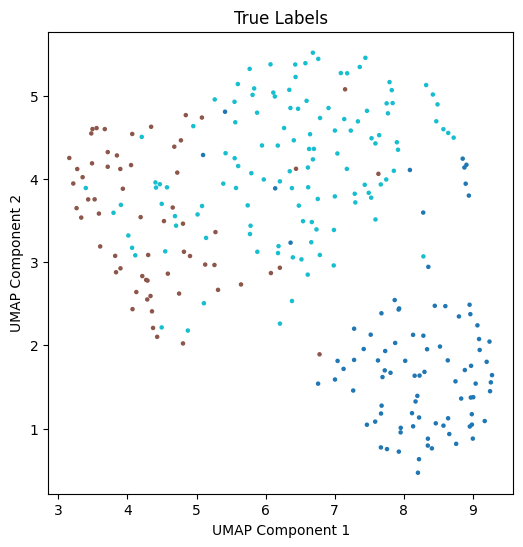

KMeans per-class results
        Correct  Incorrect
Class                     
Double       86          3
Empty        59          3
Single       95         28



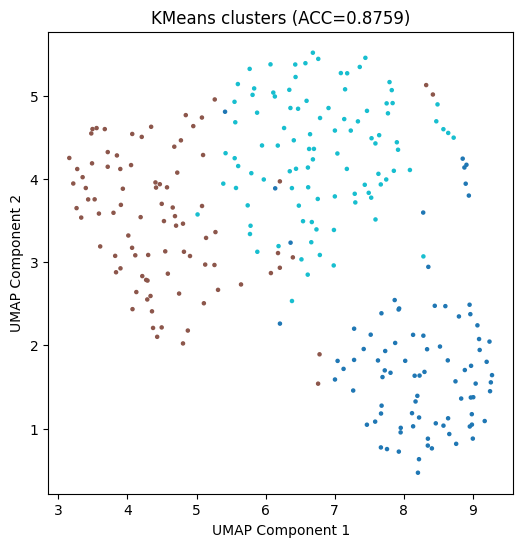

Agglomerative per-class results
        Correct  Incorrect
Class                     
Double       76         13
Empty        47         15
Single       97         26



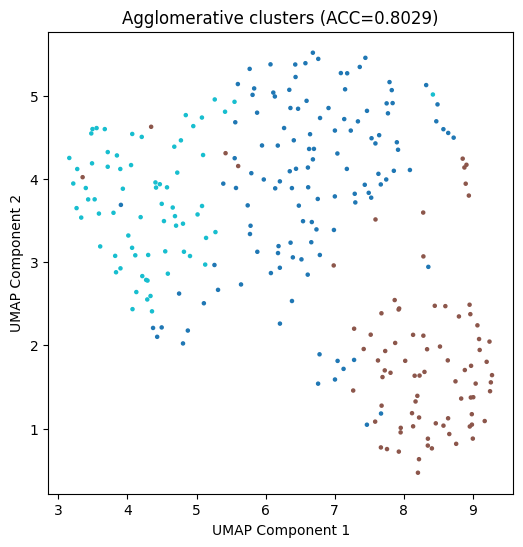

GMM per-class results
        Correct  Incorrect
Class                     
Double       86          3
Empty        59          3
Single       96         27



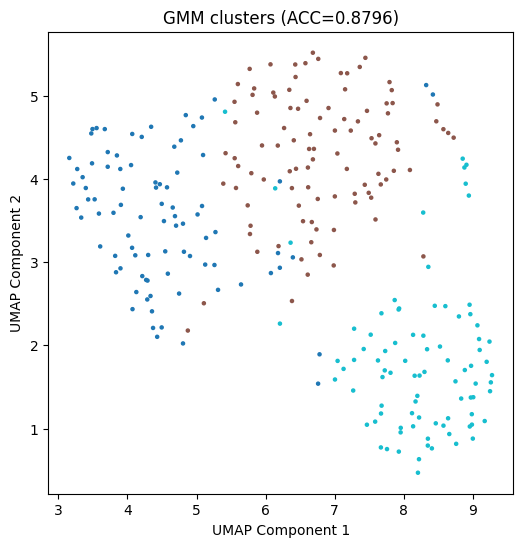

In [ ]:
# Clustering evaluation
backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
backbone = backbone.to(DEVICE).eval()
num_classes =3
# Feature extraction
features, labels = [], []
with torch.no_grad():
    for imgs, labs in test_loader:
        feats = backbone(imgs.to(DEVICE)).cpu().numpy()
        features.append(feats)
        labels.append(labs.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)
class_names = eval_full_ds.classes
print(f"Feature dimension: {X.shape[1]}")

# 2D projection via UMAP
X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

# True labels visualization
plt.figure(figsize=(6, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=5, cmap='tab10')
plt.title("True Labels")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

# Clustering algorithms
algorithms = {
    "KMeans": KMeans(n_clusters=num_classes, init='k-means++', n_init=50,random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=num_classes),
    "GMM": GaussianMixture(n_components=num_classes, covariance_type='full', random_state=42)
}

# Utility: accuracy and mapping
def cluster_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    contingency = np.zeros((D, D), dtype=int)
    for i in range(len(y_true)):
        contingency[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency)
    accuracy = contingency[row_ind, col_ind].sum() / y_true.size
    return accuracy, dict(zip(row_ind, col_ind))

# Evaluate & visualize
for name, algo in algorithms.items():
    if name == "GMM":
        y_pred = algo.fit_predict(X)
    else:
        y_pred = algo.fit(X).labels_

    acc, mapping = cluster_accuracy(y, y_pred)
    y_mapped = np.vectorize(mapping.get)(y_pred)

    rows = []
    for idx, cls in enumerate(class_names):
        mask = (y == idx)
        correct = (y_mapped[mask] == idx).sum()
        total = mask.sum()
        rows.append({"Class": cls, "Correct": correct, "Incorrect": total - correct})
    df = pd.DataFrame(rows).set_index("Class")
    print(f"{name} per-class results\n{df}\n")

    plt.figure(figsize=(6, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_pred, s=5, cmap='tab10')
    plt.title(f"{name} clusters (ACC={acc:.4f})")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.show()

In [ ]:
# Function to count images per class in test_loader
def count_images_per_class(test_loader, class_names):
    # Dictionary to store counts per class
    class_counts = {class_name: 0 for class_name in class_names}

    # Iterate over test_loader to count labels
    with torch.no_grad():
        for _, labels in test_loader:
            labels = labels.numpy()
            for label in labels:
                class_name = class_names[label]
                class_counts[class_name] += 1

    # Print the counts
    print("Image counts per class in test_loader:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")



# Count images per class
count_images_per_class(test_loader, class_names)

# Continue with clustering (e.g., KMeans or ensemble) as before

Image counts per class in test_loader:
Double: 89
Empty: 62
Single: 123


Refined KMeans per-class results
         Correct  Incorrect
Class                     
Double       64          8
Empty        45          6
Single       63         15
Refined KMeans cluster accuracy 0.8557


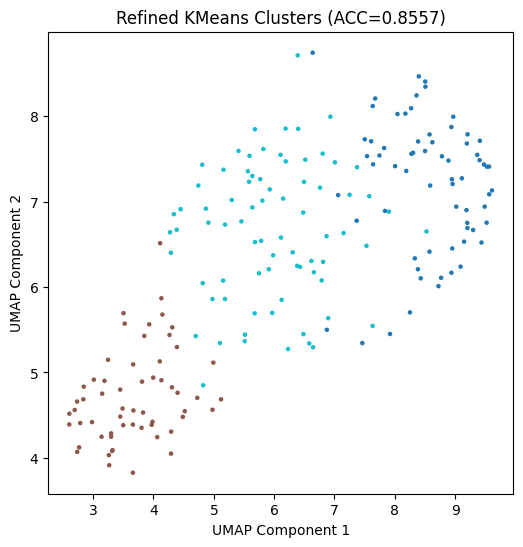

In [ ]:
# DBSCAN Refinement (updated)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.12, min_samples=6)  # Adjusted parameters
y_pred_dbscan = dbscan.fit_predict(X_pca)

# Map DBSCAN labels to KMeans clusters with distance threshold
refined_labels = y_pred_kmeans.copy()
noise_mask = (y_pred_dbscan == -1)
if np.any(noise_mask):
    noise_points = X_pca[noise_mask]
    distances = cdist(noise_points, kmeans.cluster_centers_)
    nearest_clusters = np.argmin(distances, axis=1)
    # Use 75th percentile as threshold
    distance_threshold = np.percentile(distances.min(axis=1), 75)
    for i, (dist, point_idx) in enumerate(zip(distances.min(axis=1), np.where(noise_mask)[0])):
        if dist < distance_threshold:  # Only reassign if within threshold
            refined_labels[point_idx] = nearest_clusters[i]
        else:
            refined_labels[point_idx] = -1  # Keep as noise if too far

# Focus on "Single" and "Empty"
single_idx = class_names.index("Single")
empty_idx = class_names.index("Empty")
boundary_mask = (y_pred_dbscan != -1) & (y_pred_kmeans != refined_labels)
if np.any(boundary_mask):
    boundary_points = X_pca[boundary_mask]
    boundary_distances = cdist(boundary_points, kmeans.cluster_centers_)
    boundary_nearest = np.argmin(boundary_distances, axis=1)
    for i, (dist, point_idx) in enumerate(zip(boundary_distances.min(axis=1), np.where(boundary_mask)[0])):
        if y_pred_kmeans[point_idx] in [single_idx, empty_idx] and dist < distance_threshold:
            refined_labels[point_idx] = boundary_nearest[i]

# Apply valid_mask to filter out noise
valid_mask = (refined_labels != -1)
y_clean_refined = y_clean[valid_mask]
refined_labels_valid = refined_labels[valid_mask]
X_pca_refined = X_pca[valid_mask]
X_2d_clean_refined = X_2d_clean[valid_mask]

# Map refined labels to true labels
acc, mapping = cluster_accuracy(y_clean_refined, refined_labels_valid)
y_mapped = np.vectorize(mapping.get)(refined_labels_valid)

# Per-class results
rows = []
for idx, cls in enumerate(class_names):
    mask = (y_clean_refined == idx)
    correct = (y_mapped[mask] == idx).sum()
    total = mask.sum()
    rows.append({"Class": cls, "Correct": correct, "Incorrect": total - correct})
df = pd.DataFrame(rows).set_index("Class")
print("Refined KMeans per-class results\n", df)
print(f"Refined KMeans cluster accuracy {acc:.4f}")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(X_2d_clean_refined[:, 0], X_2d_clean_refined[:, 1], c=refined_labels_valid, s=5, cmap='tab10')
plt.title(f"Refined KMeans Clusters (ACC={acc:.4f})")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Ensemble Clustering per-class results
         Correct  Incorrect
Class                     
Double       84          3
Empty        56          3
Single       95         27
Ensemble Clustering accuracy 0.8769


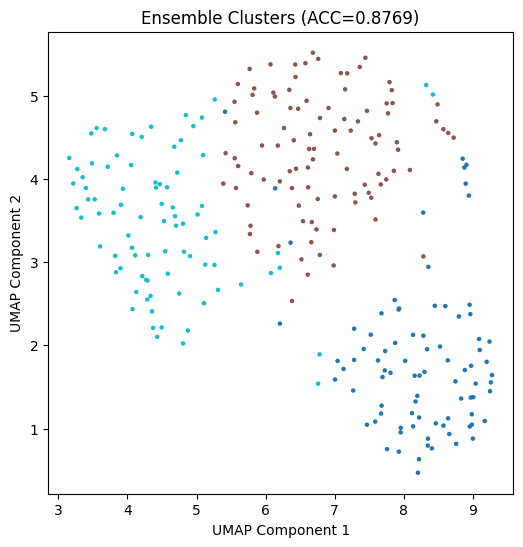

In [ ]:
# Clustering evaluation
backbone.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
backbone = backbone.to(DEVICE).eval()

# Feature extraction
features, labels = [], []
with torch.no_grad():
    for imgs, labs in test_loader:
        feats = backbone(imgs.to(DEVICE)).cpu().numpy()
        features.append(feats)
        labels.append(labs.numpy())

X = np.concatenate(features, axis=0)
y = np.concatenate(labels, axis=0)
X_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(X)

# Outlier removal
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
outlier_labels = iso_forest.fit_predict(X)
X_clean = X[outlier_labels == 1]
y_clean = y[outlier_labels == 1]
X_2d_clean = X_2d[outlier_labels == 1]

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_clean)

# Individual clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
algorithms = {
    "KMeans": KMeans(n_clusters=num_classes, init='k-means++', n_init=150, max_iter=300, tol=1e-4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=num_classes),
    "GMM": GaussianMixture(n_components=num_classes, covariance_type='full', random_state=42)
}

clusterings = {}
for name, algo in algorithms.items():
    if name == "GMM":
        clusterings[name] = algo.fit_predict(X_pca)
    else:
        clusterings[name] = algo.fit(X_pca).labels_

# Create co-association matrix
n_samples = X_pca.shape[0]
co_assoc = np.zeros((n_samples, n_samples))
for labels in clusterings.values():
    for i in range(n_samples):
        for j in range(n_samples):
            if labels[i] == labels[j]:
                co_assoc[i, j] += 1
co_assoc = co_assoc / len(clusterings)

# Ensemble clustering with SpectralClustering
from sklearn.cluster import SpectralClustering
ensemble_clustering = SpectralClustering(n_clusters=num_classes, affinity='precomputed', random_state=42).fit(co_assoc)
y_pred_ensemble = ensemble_clustering.labels_

# Apply valid_mask to filter out potential noise (if any from previous steps)
valid_mask = np.ones(n_samples, dtype=bool)  # Initially all true, adjust if needed
y_clean_refined = y_clean[valid_mask]
y_pred_ensemble_refined = y_pred_ensemble[valid_mask]

# Accuracy
def cluster_accuracy(y_true, y_pred):
    D = max(y_pred.max(), y_true.max()) + 1
    contingency = np.zeros((D, D), dtype=int)
    for i in range(len(y_true)):
        contingency[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency)
    accuracy = contingency[row_ind, col_ind].sum() / y_true.size
    return accuracy, dict(zip(row_ind, col_ind))

acc, mapping = cluster_accuracy(y_clean_refined, y_pred_ensemble_refined)
y_mapped = np.vectorize(mapping.get)(y_pred_ensemble_refined)

# Per-class results
class_names = eval_full_ds.classes
rows = []
for idx, cls in enumerate(class_names):
    mask = (y_clean_refined == idx)
    correct = (y_mapped[mask] == idx).sum()
    total = mask.sum()
    rows.append({"Class": cls, "Correct": correct, "Incorrect": total - correct})
df = pd.DataFrame(rows).set_index("Class")
print("Ensemble Clustering per-class results\n", df)
print(f"Ensemble Clustering accuracy {acc:.4f}")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(X_2d_clean[valid_mask, 0], X_2d_clean[valid_mask, 1], c=y_pred_ensemble_refined, s=5, cmap='tab10')
plt.title(f"Ensemble Clusters (ACC={acc:.4f})")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()